<a href="https://colab.research.google.com/github/theQuert/inlpfun/blob/master/Demo/Sentiment_Analysis_of_Covid19_Vaccination_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Mon Dec  6 06:41:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip3 install transformers

In [4]:
import re
import numpy as np
import pandas as pd
import os, json
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")

#### Training

In [6]:
cd /content/drive/MyDrive/Colab Notebooks/NCCU_BG21

/content/drive/MyDrive/Colab Notebooks/NCCU_BG21


In [7]:
df = pd.read_csv('tweet_dataset.csv')
df.head()

,textID,sentiment,author,text,old_text,aux_id,new_sentiment,selected_text
0,1956967341,empty,xoshayzers,i know i was listenin to bad habit earlier a...,@tiffanylue i know i was listenin to bad habi...,p1000000000,NaN,NaN
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,Layin n bed with a headache ughhhh...waitin o...,c811396dc2,negative,headache
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,We want to trade with someone who has Houston...,@dannycastillo We want to trade with someone w...,82565a56d3,neutral,We want to trade with someone who has Houston ...


We only extract `text` and `new_sentiment`

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         40000 non-null  int64 
 1   sentiment      40000 non-null  object
 2   author         40000 non-null  object
 3   text           39934 non-null  object
 4   old_text       40000 non-null  object
 5   aux_id         40000 non-null  object
 6   new_sentiment  31395 non-null  object
 7   selected_text  27767 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.4+ MB


In [9]:
train = pd.DataFrame()
train['text'] = df['text']
train['Sentiment'] = df['new_sentiment']

Drop NaN

In [10]:
train = train.dropna()
train.isnull().sum()

text         0
Sentiment    0
dtype: int64

In [11]:
train['Sentiment'] = train['Sentiment'].replace(['negative', 'neutral', 'positive'], [0, 1, 2])

In [12]:
train.head()

,text,Sentiment
1,Layin n bed with a headache ughhhh...waitin o...,0
2,Funeral ceremony...gloomy friday...,0
3,wants to hang out with friends SOON!,2
4,We want to trade with someone who has Houston...,1
5,Re-pinging : why didn`t you go to prom? BC my ...,0


#### Importing BERT Tokenizer

In [13]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)
# tokenizer.encode()
# toknizer.tokenize()
# tokenizer.convert_texts_to_ids()

#### Preprocessing

In [14]:
max_len = 0


for tweet in train['text']:
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)

    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    max_len = max(max_len, len(input_ids))

print('Max sequence length: ', max_len)

Max sequence length:  110


In [ ]:
input_ids = []
attention_masks = []

for sent in train['text']:
    encoded_dict = tokenizer.encode_plus(
        sent,
        # padding=True, 
        truncation=True,
        max_length=110,
        pad_to_max_length=True,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train['Sentiment'].tolist())

#### Datasets and DataLoaders

In [16]:
from torch.utils.data import TensorDataset, random_split
# Create the dataset wrapping tensors 
# input_ids, attention_masks, labels
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)
validation_dataloader = DataLoader(
    val_dataset,
    sampler = RandomSampler(val_dataset),
    batch_size = batch_size
)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
)

#### Optimizer and Scheduler

In [19]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps=1e-8)

In [20]:
from transformers import get_linear_schedule_with_warmup
epochs = 4

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

In [21]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [22]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### Training Loop

In [ ]:
import random
epochs=5

model.to(device)

training_stats = []
total_t0 = time.time()
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        result = model(b_input_ids,
                       token_type_ids = None,
                       attention_mask = b_attention_mask,
                       labels = b_labels,
                       return_dict=True)
        
        loss = result.loss
        logits = result.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print(" Average training loss: {0:.2f}".format(avg_train_loss))
    print(" Training epcoh took: {:}".format(training_time))

In [ ]:
print("Running Validation...")
t0 = time.time()

model.eval()

total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0
for batch in validation_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)
        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

#### Prediction

In [25]:
df_vax = pd.read_csv('vaccination_all_tweets.csv')
df_vax.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [26]:
df_vax_weeks = df_vax.copy()
# df_vax_weeks['date'] = pd.to_datetime(df_vax_weeks['date'], format='%Y%m%d', unit='s')
start_date = '2021-11-01 0:00:00'
end_date = '2021-11-20 23:59:59'
mask = (df_vax_weeks['date'] > start_date) & (df_vax_weeks['date'] <= end_date)

df_vax_weeks = df_vax_weeks.loc[mask]

In [27]:
# df_vax_weeks.head()
df_vax_weeks.shape

(12692, 16)

In [28]:
df_vax_weeks.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
212982,1456709334784696327,Noor Hussain,NaN,NaN,2018-06-10 09:02:47,5,0,2,False,2021-11-05 19:45:44,Anyone need squid coins or sell coins retweet ...,"['squid', 'ThankYouBrandon', 'PfizerBiontech']",Twitter Web App,0,0,False
212983,1456179996301557768,livsnjutare🌸,"Davao City, Davao Region",To Be the Light of Someone’s Life.,2020-08-24 08:41:33,13,13,446,False,2021-11-04 08:42:20,I'm fully vaccinated!💉\n#PfizerBioNTech,['PfizerBioNTech'],Twitter for Android,0,0,False
212984,1455255454687260675,Liam O'Mara IV 📚😼🌹🧢🤘,SoCal,"Ph.D. prof. of history, antifascist, pacifist,...",2013-07-01 23:12:25,8344,3916,8808,True,2021-11-01 19:28:32,"In queue for my #PfizerBioNTech #booster shot,...","['PfizerBioNTech', 'booster']",Twitter for Android,0,7,False
212985,1455164740548898823,BizToc News,NaN,➡ Follow @biztoc,2009-11-01 13:19:56,42,2,0,False,2021-11-01 13:28:04,FDA Delays Approval Of Moderna Jab For Kids As...,"['pfizerbiontech', 'hill']",BizToc,1,1,False
213002,1455305339113394176,China Perspective,Beijing,China_Perspective is a non-profit organization...,2017-05-23 00:50:50,92713,37,126,True,2021-11-01 22:46:45,#Tanzania on Monday received the second batch ...,"['Tanzania', 'Sinopharm']",Twitter for Android,2,13,False


In [29]:
# extract texts
vax_tweets = df_vax_weeks['text']

#### Pre-processing tweets

In [30]:
input_ids = []
attention_masks = []

for tweet in vax_tweets:
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)
    tweet = re.sub(r'\S+\.com\S+','', tweet)
    tweet = re.sub(r'\@\w+','', tweet)
    tweet = re.sub("\ ","", tweet)
    tweet = re.sub("\'","", tweet)
    tweet = re.sub("\\n'","", tweet)
    tweet = re.sub('#\w+', '', tweet)

    encoded_dict = tokenizer.encode_plus(
        tweet,
        add_special_tokens = True,
        max_length = 110,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, 0)
attention_masks = torch.cat(attention_masks, 0)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [31]:
'''
text = re.sub(r"http\S+", "", text) #remove urls
text = re.sub(r'\S+\.com\S+','',text) #remove urls
text = re.sub(r'\@\w+','',text) #remove mentions
text = re.sub(r'\#\w+','',text) #remove hashtags
'''

'\ntext = re.sub(r"http\\S+", "", text) #remove urls\ntext = re.sub(r\'\\S+\\.com\\S+\',\'\',text) #remove urls\ntext = re.sub(r\'\\@\\w+\',\'\',text) #remove mentions\ntext = re.sub(r\'\\#\\w+\',\'\',text) #remove hashtags\n'

#### Dataset and DataLoader

In [32]:
# from torch.utils.data import TensorDataset, random_split
# # Create the dataset wrapping tensors 
# # input_ids, attention_masks, labels
# dataset = TensorDataset(input_ids, attention_masks, labels)
# train_size = int(0.9*len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

from torch.utils.data import TensorDataset, random_split
vax_dataset = TensorDataset(input_ids, attention_masks)
vax_dataloader = DataLoader(
    vax_dataset,
    sampler = SequentialSampler(vax_tweets),
    batch_size = batch_size
)

#### Prediction

In [33]:
print(f'Predicting sentiment for {len(input_ids)} vaccine tweets')
model.eval()

predictions = []

for batch in vax_dataloader:
 
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask = batch

  with torch.no_grad():

      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits
  logits = logits.detach().cpu().numpy()
  logits=np.argmax(logits,axis=1)
  
  for i in range(len(logits)):
      predictions.append(logits[i])
print('DONE')

Predicting sentiment for 12692 vaccine tweets
DONE


In [34]:
df_vax_weeks['Sentiment'] = predictions
df_vax_weeks = df_vax_weeks.dropna()
df_vax_weeks.isnull().sum()
df_vax_weeks.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,Sentiment
212983,1456179996301557768,livsnjutare🌸,"Davao City, Davao Region",To Be the Light of Someone’s Life.,2020-08-24 08:41:33,13,13,446,False,2021-11-04 08:42:20,I'm fully vaccinated!💉\n#PfizerBioNTech,['PfizerBioNTech'],Twitter for Android,0,0,False,2
212984,1455255454687260675,Liam O'Mara IV 📚😼🌹🧢🤘,SoCal,"Ph.D. prof. of history, antifascist, pacifist,...",2013-07-01 23:12:25,8344,3916,8808,True,2021-11-01 19:28:32,"In queue for my #PfizerBioNTech #booster shot,...","['PfizerBioNTech', 'booster']",Twitter for Android,0,7,False,1
213002,1455305339113394176,China Perspective,Beijing,China_Perspective is a non-profit organization...,2017-05-23 00:50:50,92713,37,126,True,2021-11-01 22:46:45,#Tanzania on Monday received the second batch ...,"['Tanzania', 'Sinopharm']",Twitter for Android,2,13,False,1
213003,1455278479302434817,China Science,"Beijing, China",Timely updates info on advanced technology and...,2019-08-23 16:40:11,1867917,10,0,True,2021-11-01 21:00:01,#Tanzania on Monday received the second batch ...,"['Tanzania', 'Sinopharm']",TweetDeck,11,66,False,1
213004,1455263373277515796,"People's Daily, China","Beijing, China",The largest newspaper in China,2011-05-23 15:00:26,6893462,4347,1063,True,2021-11-01 20:00:00,#Tanzania on Monday received the second batch ...,"['Tanzania', 'Sinopharm']",TweetDeck,17,22,False,1


In [35]:
df_vax_weeks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7541 entries, 212983 to 228206
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                7541 non-null   int64 
 1   user_name         7541 non-null   object
 2   user_location     7541 non-null   object
 3   user_description  7541 non-null   object
 4   user_created      7541 non-null   object
 5   user_followers    7541 non-null   int64 
 6   user_friends      7541 non-null   int64 
 7   user_favourites   7541 non-null   int64 
 8   user_verified     7541 non-null   bool  
 9   date              7541 non-null   object
 10  text              7541 non-null   object
 11  hashtags          7541 non-null   object
 12  source            7541 non-null   object
 13  retweets          7541 non-null   int64 
 14  favorites         7541 non-null   int64 
 15  is_retweet        7541 non-null   bool  
 16  Sentiment         7541 non-null   int64 
dtypes: bool

In [36]:
vax = df_vax_weeks.drop(['user_name', 'user_description', 'user_created', 'user_followers',
                   'user_friends', 'user_favourites', 'source', 'is_retweet'], axis=1)
# Concern saving the followers for more analysis

In [37]:
vax.head()

,id,user_location,user_verified,date,text,hashtags,retweets,favorites,Sentiment
212983,1456179996301557768,"Davao City, Davao Region",False,2021-11-04 08:42:20,I'm fully vaccinated!💉\n#PfizerBioNTech,['PfizerBioNTech'],0,0,2
212984,1455255454687260675,SoCal,True,2021-11-01 19:28:32,"In queue for my #PfizerBioNTech #booster shot,...","['PfizerBioNTech', 'booster']",0,7,1
213002,1455305339113394176,Beijing,True,2021-11-01 22:46:45,#Tanzania on Monday received the second batch ...,"['Tanzania', 'Sinopharm']",2,13,1
213003,1455278479302434817,"Beijing, China",True,2021-11-01 21:00:01,#Tanzania on Monday received the second batch ...,"['Tanzania', 'Sinopharm']",11,66,1
213004,1455263373277515796,"Beijing, China",True,2021-11-01 20:00:00,#Tanzania on Monday received the second batch ...,"['Tanzania', 'Sinopharm']",17,22,1


In [38]:
vax['text'] = vax['text'].str.replace('#[A-Za-z0-9_]+', '', regex=True)
vax['text'] = vax['text'].str.replace('@[A-Za-z0-9_]+', '', regex=True)
vax['text'] = vax['text'].str.replace('https?://\S+|www\.\S+', '', regex=True)
vax['text'] = vax['text'].str.replace("\\n'", "", regex=True)

In [39]:
vax['text'].head()

212983                             I'm fully vaccinated!💉\n
212984    In queue for my   shot, because I'm with the s...
213002     on Monday received the second batch of 500,00...
213003     on Monday received the second batch of 500,00...
213004     on Monday received the second batch of 500,00...
Name: text, dtype: object

In [40]:
vax['Sentiment'] = vax['Sentiment'].replace([0, 1, 2], ['negative', 'neutral', 'positive'])
# vax['Sentiment'] = vax['Sentiment'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

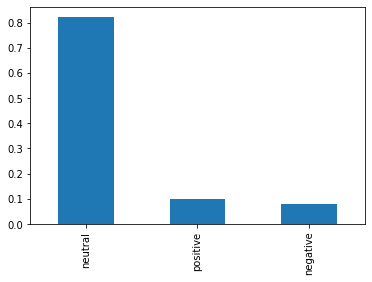

In [41]:
vax['Sentiment'].value_counts(normalize=True).plot.bar()

In [42]:
vax['date'] = pd.to_datetime(vax['date'], errors='coerce').dt.date
vax['Sentiment'] = vax['Sentiment'].replace(['negative', 'neutral', 'positive'],
                                            [-1, 0, 1])
# vax['Sentiment'] = vax['Sentiment'].map({'negative': -1, 'nrutral': 0, 'positive': 1})

In [43]:
vax.head()

,id,user_location,user_verified,date,text,hashtags,retweets,favorites,Sentiment
212983,1456179996301557768,"Davao City, Davao Region",False,2021-11-04,I'm fully vaccinated!💉\n,['PfizerBioNTech'],0,0,1
212984,1455255454687260675,SoCal,True,2021-11-01,"In queue for my shot, because I'm with the s...","['PfizerBioNTech', 'booster']",0,7,0
213002,1455305339113394176,Beijing,True,2021-11-01,"on Monday received the second batch of 500,00...","['Tanzania', 'Sinopharm']",2,13,0
213003,1455278479302434817,"Beijing, China",True,2021-11-01,"on Monday received the second batch of 500,00...","['Tanzania', 'Sinopharm']",11,66,0
213004,1455263373277515796,"Beijing, China",True,2021-11-01,"on Monday received the second batch of 500,00...","['Tanzania', 'Sinopharm']",17,22,0


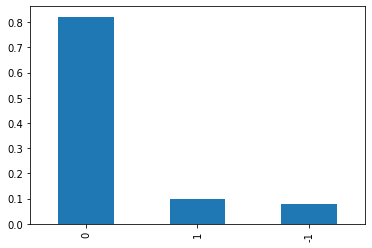

In [44]:
vax['Sentiment'].value_counts(normalize=True).plot.bar()

In [45]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik', 'johnson']

vax_sentiment = pd.DataFrame()
vax_sentiment['Vaccine'] = all_vax
sentiments=list()

#### Vaccine with Time

In [46]:
def time_variance(vacc) :
    if vacc=='all':
        vacc=vax
    else :   
        vacc=vax[vax['text'].str.lower().str.contains(vacc)]
        sentiments.append(vacc.Sentiment.mean())

    temp=pd.DataFrame()
    temp['date'] = sorted(vacc['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(vacc[vacc['date']==date].Sentiment.mean())

    temp['Sentiment']=senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title("Variance of Sentiment wrt Time",size=24)
    axs.grid()

#### Mean overall sentiment

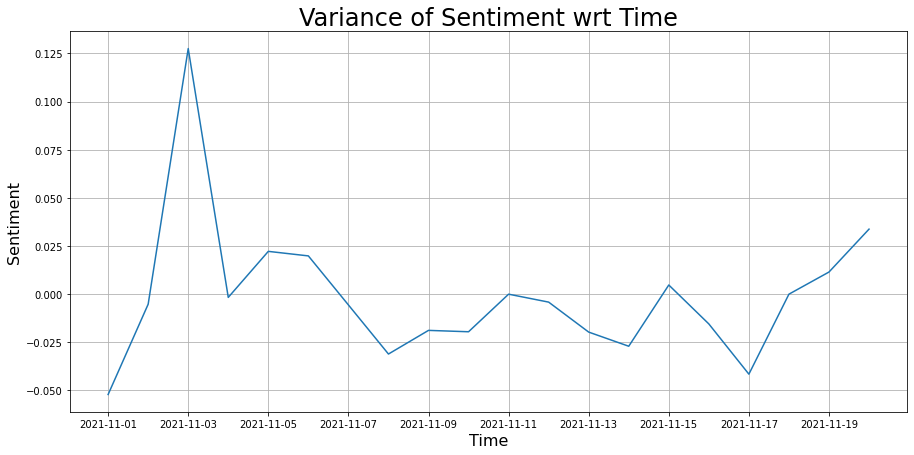

In [47]:
time_variance('all')

#### Moderna

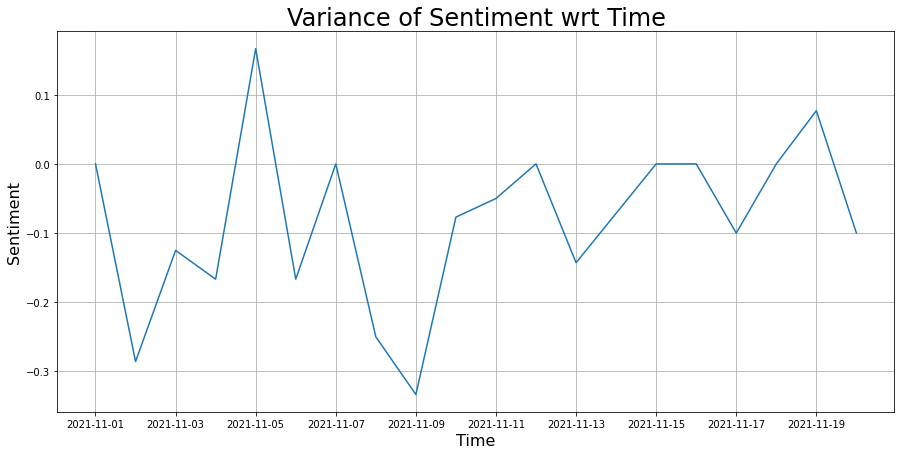

In [51]:
time_variance('moderna')

#### Pfizer

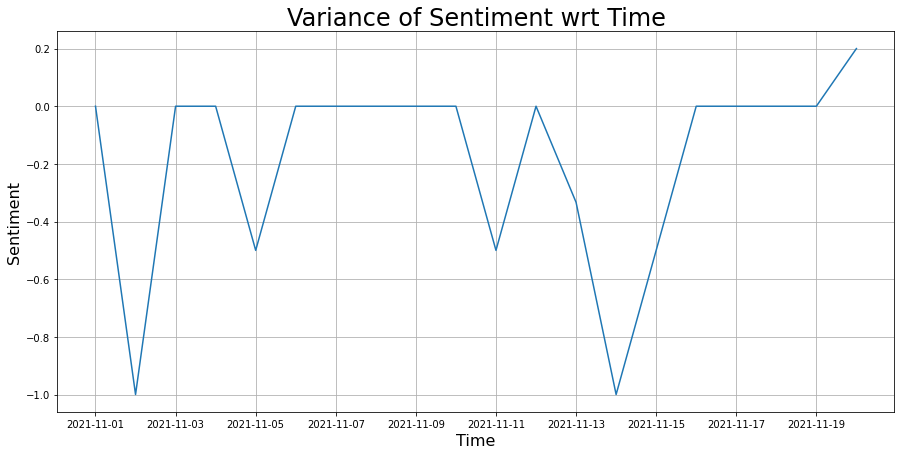

In [52]:
time_variance('pfizer')

#### Johnson&Johnson

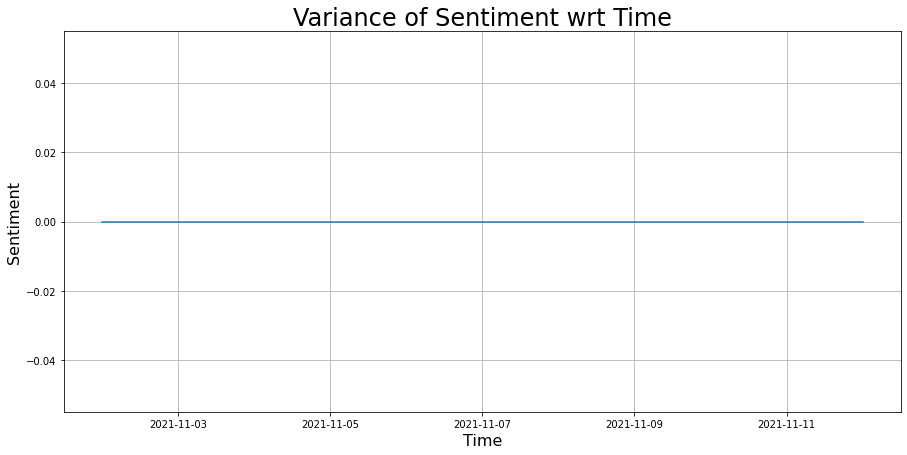

In [57]:
time_variance('johnson')    

#### Covaxin

In [ ]:
# time_variance('covaxin')

#### ~Sinopharm~

In [49]:
# time_variance('sinopharm')

#### ~Sinovac~

In [50]:
# time_variance('sinovac')

#### ~Biontech~

In [53]:
# time_variance('biontech')

#### ~Oxford~

In [54]:
# time_variance('oxford')

#### ~Astrazenca~

In [55]:
# time_variance('astrazeneca')

#### ~Sputnik~

In [56]:
# time_variance('sputnik')

### Comparison among Countries

In [58]:
def time_variance_country(country) :
    count = vax[vax['user_location'].str.lower().str.contains(country)]

    temp=pd.DataFrame()
    temp['date'] = sorted(count['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(count[count['date']==date].Sentiment.mean())

    temp['Sentiment'] = senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title(f"Variance of Sentiment wrt Time",size=24)
    axs.grid()

In [ ]:
# time_variance_country('india')

In [ ]:
# time_variance_country('canada')

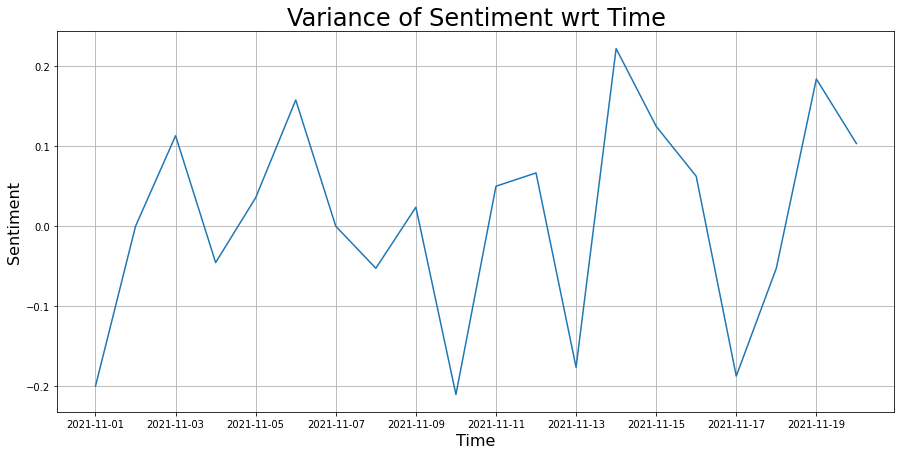

In [61]:
time_variance_country('usa')

The variance of sentiments in different countries seems to be more erratic. The varition might be the politics and economic matters among them.

# WordCloud

In [62]:
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
df_vax_tweets = vax_tweets.to_frame()
text_for_wd = str(df_vax_tweets['text'].values)

In [64]:
text_for_wd_pro = re.sub(r"http\S+", "", text_for_wd)
text_for_wd_pro = re.sub(r'\S+\.com\S+','', text_for_wd_pro)
text_for_wd_pro = re.sub(r'\@\w+','', text_for_wd_pro)
text_for_wd_pro = re.sub("\ ","", text_for_wd_pro)
text_for_wd_pro = re.sub("\'","", text_for_wd_pro)
text_for_wd_pro = re.sub("\\n'","", text_for_wd_pro)

(-0.5, 999.5, 499.5, -0.5)

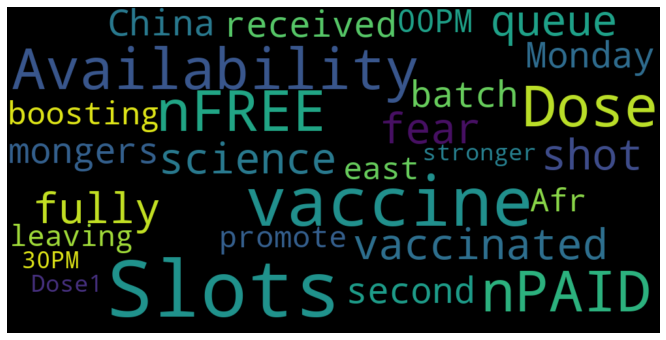

In [65]:
# without hashtags
words = str(vax['text'].values)
word_cloud = WordCloud(width=1000, height=500, max_font_size=120).generate(words)
fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 999.5, 499.5, -0.5)

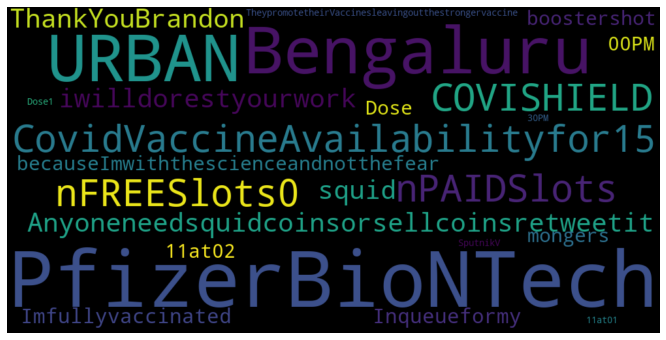

In [66]:
# with hashtags
words = text_for_wd_pro
word_cloud = WordCloud(width=1000, height=500, max_font_size=120).generate(words)
fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

# Topic Modeling (recent 2 weeks)

In [ ]:
!pip3 install pyLDAvis spacy cssselect
!python3 -m spacy download en_core_web_sm

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import spacy
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()
en_stop = set(nltk.corpus.stopwords.words('english'))

In [69]:
df_vax_tweets.head()

,text
212982,Anyone need squid coins or sell coins retweet ...
212983,I'm fully vaccinated!💉\n#PfizerBioNTech
212984,"In queue for my #PfizerBioNTech #booster shot,..."
212985,FDA Delays Approval Of Moderna Jab For Kids As...
213002,#Tanzania on Monday received the second batch ...


In [ ]:
df_vax_tweets['text'] = df_vax_tweets['text'].str.replace('#[A-Za-z0-9_]+', '', regex=True)
df_vax_tweets['text'] = df_vax_tweets['text'].str.replace('@[A-Za-z0-9_]+', '', regex=True)
df_vax_tweets['text'] = df_vax_tweets['text'].str.replace('https?://\S+|www\.\S+', '', regex=True)
df_vax_tweets['text'] = df_vax_tweets['text'].str.replace("\\n'", "", regex=True)

In [71]:
df_vax_tweets.head()

,text
212982,Anyone need squid coins or sell coins retweet ...
212983,I'm fully vaccinated!💉\n
212984,"In queue for my shot, because I'm with the s..."
212985,FDA Delays Approval Of Moderna Jab For Kids As...
213002,"on Monday received the second batch of 500,00..."


In [72]:
df_vax_wks = df_vax_weeks.copy()

In [73]:
df_vax_wks.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,Sentiment
212983,1456179996301557768,livsnjutare🌸,"Davao City, Davao Region",To Be the Light of Someone’s Life.,2020-08-24 08:41:33,13,13,446,False,2021-11-04 08:42:20,I'm fully vaccinated!💉\n#PfizerBioNTech,['PfizerBioNTech'],Twitter for Android,0,0,False,2
212984,1455255454687260675,Liam O'Mara IV 📚😼🌹🧢🤘,SoCal,"Ph.D. prof. of history, antifascist, pacifist,...",2013-07-01 23:12:25,8344,3916,8808,True,2021-11-01 19:28:32,"In queue for my #PfizerBioNTech #booster shot,...","['PfizerBioNTech', 'booster']",Twitter for Android,0,7,False,1
213002,1455305339113394176,China Perspective,Beijing,China_Perspective is a non-profit organization...,2017-05-23 00:50:50,92713,37,126,True,2021-11-01 22:46:45,#Tanzania on Monday received the second batch ...,"['Tanzania', 'Sinopharm']",Twitter for Android,2,13,False,1
213003,1455278479302434817,China Science,"Beijing, China",Timely updates info on advanced technology and...,2019-08-23 16:40:11,1867917,10,0,True,2021-11-01 21:00:01,#Tanzania on Monday received the second batch ...,"['Tanzania', 'Sinopharm']",TweetDeck,11,66,False,1
213004,1455263373277515796,"People's Daily, China","Beijing, China",The largest newspaper in China,2011-05-23 15:00:26,6893462,4347,1063,True,2021-11-01 20:00:00,#Tanzania on Monday received the second batch ...,"['Tanzania', 'Sinopharm']",TweetDeck,17,22,False,1


In [74]:
# df_vax_wks['text'] = df_vax_wks['text'].str.replace('#[A-Za-z0-9_]+', '', regex=True)
df_vax_wks['text'] = df_vax_wks['text'].str.replace('#', '', regex=True)
df_vax_wks['text'] = df_vax_wks['text'].str.replace('@[A-Za-z0-9_]+', '', regex=True)
df_vax_wks['text'] = df_vax_wks['text'].str.replace('https?://\S+|www\.\S+', '', regex=True)
df_vax_wks['text'] = df_vax_wks['text'].str.replace("\\n'", "", regex=True)

<input>:4: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \S
<ipython-input-74-c374bb54aab8>:4: DeprecationWarning: invalid escape sequence \S
  df_vax_wks['text'] = df_vax_wks['text'].str.replace('https?://\S+|www\.\S+', '', regex=True)


In [75]:
df_vax_wks.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,Sentiment
212983,1456179996301557768,livsnjutare🌸,"Davao City, Davao Region",To Be the Light of Someone’s Life.,2020-08-24 08:41:33,13,13,446,False,2021-11-04 08:42:20,I'm fully vaccinated!💉\nPfizerBioNTech,['PfizerBioNTech'],Twitter for Android,0,0,False,2
212984,1455255454687260675,Liam O'Mara IV 📚😼🌹🧢🤘,SoCal,"Ph.D. prof. of history, antifascist, pacifist,...",2013-07-01 23:12:25,8344,3916,8808,True,2021-11-01 19:28:32,"In queue for my PfizerBioNTech booster shot, b...","['PfizerBioNTech', 'booster']",Twitter for Android,0,7,False,1
213002,1455305339113394176,China Perspective,Beijing,China_Perspective is a non-profit organization...,2017-05-23 00:50:50,92713,37,126,True,2021-11-01 22:46:45,Tanzania on Monday received the second batch o...,"['Tanzania', 'Sinopharm']",Twitter for Android,2,13,False,1
213003,1455278479302434817,China Science,"Beijing, China",Timely updates info on advanced technology and...,2019-08-23 16:40:11,1867917,10,0,True,2021-11-01 21:00:01,Tanzania on Monday received the second batch o...,"['Tanzania', 'Sinopharm']",TweetDeck,11,66,False,1
213004,1455263373277515796,"People's Daily, China","Beijing, China",The largest newspaper in China,2011-05-23 15:00:26,6893462,4347,1063,True,2021-11-01 20:00:00,Tanzania on Monday received the second batch o...,"['Tanzania', 'Sinopharm']",TweetDeck,17,22,False,1


In [76]:
df_vax_wks = df_vax_weeks.drop(['user_name', 'user_description', 'user_created', 'user_followers',
                   'user_friends', 'user_favourites', 'source', 'is_retweet', 'id', 'user_location', 'user_verified', 'hashtags', 'retweets', 'favorites'], axis=1)

In [77]:
df_vax_wks['text'] = df_vax_wks['text'].str.replace('#', '', regex=True)

In [78]:
df_vax_wks.head()

,date,text,Sentiment
212983,2021-11-04 08:42:20,I'm fully vaccinated!💉\nPfizerBioNTech,2
212984,2021-11-01 19:28:32,"In queue for my PfizerBioNTech booster shot, b...",1
213002,2021-11-01 22:46:45,Tanzania on Monday received the second batch o...,1
213003,2021-11-01 21:00:01,Tanzania on Monday received the second batch o...,1
213004,2021-11-01 20:00:00,Tanzania on Monday received the second batch o...,1


In [79]:
# import re

# def split_it(text):
#     text = re.sub(r"http\S+", "", text)
#     text = re.sub(r'\S+\.com\S+','', text)
#     text = re.sub(r'\@\w+','', text)
#     text = re.sub("\ ","", text)
#     text = re.sub("\'","", text)
#     text = re.sub("\\n'","", text)
#     return text

In [80]:
df_vax_pre = df_vax_wks.copy()

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [82]:
from nltk.stem.wordnet import WordNetLemmatizer
import spacy

In [ ]:
# Preprocessing texts

def make_lower_case(text):
    return text.lower()

def make_tokenize(text):
    return [w for w in text.split()]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]
    
def remove_stop_words(text):
    stop_words = set(stopwords.words("english"))
    text = [w for w in text if not w in stop_words]
    texts = [w for w in text if w.isalpha()]
    texts = " ".join(texts)
    return texts

'''
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text
'''

'''
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)
'''

df_vax_pre['text'] = df_vax_pre['text'].apply(make_lower_case)
df_vax_pre['text'] = df_vax_pre['text'].apply(make_tokenize)
df_vax_pre['text'] = df_vax_pre['text'].apply(lemmatize)
df_vax_pre['text'] = df_vax_pre['text'].apply(remove_stop_words)

In [84]:
df_vax_pre.head()

,date,text,Sentiment
212983,2021-11-04 08:42:20,fully pfizerbiontech,2
212984,2021-11-01 19:28:32,queue pfizerbiontech booster science,1
213002,2021-11-01 22:46:45,tanzania monday received second batch sinophar...,1
213003,2021-11-01 21:00:01,tanzania monday received second batch sinophar...,1
213004,2021-11-01 20:00:00,tanzania monday received second batch sinophar...,1


In [ ]:
!pip3 install sentence-transformers
# # !pip3 install umap-learn
!pip3 install bertopic bertopic[visualization]
# # !pip install hdbscan --no-build-isolation --no-binary :all:

In [86]:
# create embeddings with pre-trained model

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

sentences = []
for id in range(df_vax_pre.shape[0]):
    sentences.append(df_vax_pre.iloc[id, :]['text'])

embeddings = model.encode(sentences, show_progress_bar=True)

Batches:   0%|          | 0/236 [00:00<?, ?it/s]

In [87]:
# # UMAP - Dimensinality Reduction
# from umap import UMAP

# umap_embeddings = UMAP(n_neighbors=15, 
#                             n_components=5, 
#                             metric='cosine').fit_transform(embeddings)

In [88]:
# import hdbscan.HDBSCAN

# cluster = HDBSCAN(min_cluster_size=15,
#                           metric='euclidean',                      
#                           cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
from bertopic import BERTopic
topic_model = BERTopic(min_topic_size=35, verbose=True)
topics, _ = topic_model.fit_transform(sentences)

In [90]:
freq = topic_model.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,2115,-1_covid_day_travel_trump
1,0,375,0_sinovac_sinopharm_china_chinese
2,1,355,1_urban_paid_bengaluru_availability
3,2,243,2_approval_approve_approved_eul
4,3,241,3_vaccigen_vaccinated_efficacy_vaccinequity
5,4,210,4_bbmp_bengaluru_availability_free
6,5,200,5_marketing_cher_victoriamonet_music
7,6,198,6_vaccinated_vaccination_safe_dose
8,7,187,7_bbmp_paid_bengaluru_availability
9,8,173,8_fda_pfizer_shot_authorization


In [91]:
topic_nr = freq.iloc[3]["Topic"]  # We select a frequent topic
topic_model.get_topic(topic_nr)   # You can select a topic number as shown above

[('approval', 0.06703093599989708),
 ('approve', 0.050124531249745044),
 ('approved', 0.035293958476695454),
 ('eul', 0.027274291031425014),
 ('eua', 0.026027660523174657),
 ('approvel', 0.017629577692866334),
 ('approving', 0.017451892362008347),
 ('approves', 0.016388913106369377),
 ('delay', 0.012029406032494607),
 ('approvecovaxin', 0.011492214585762646)]

In [ ]:
fig = topic_model.visualize_topics();

In [93]:
fig

In [94]:
topic_model.visualize_barchart()

In [95]:
timestamps = df_vax_wks['date'].to_list()

topics_over_time = topic_model.topics_over_time(docs=sentences, 
                                                topics=topics, 
                                                timestamps=timestamps, 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=20)

20it [00:20,  1.02s/it]


In [96]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

In [97]:
topic_model.get_representative_docs()

{0: ['expert hailed move add sinopharm list approved vaccine inbound traveler',
  'uk border vaccine news add listed chinese sinopharm sinovac vaccine recognised list',
  'uk add sinopharm sinovac approved vaccine list uk sinovac'],
 1: ['urban bengaluru covidvaccine availability free slot paid slot covishield',
  'urban bengaluru covidvaccine availability free slot paid slot covishield',
  'urban bengaluru covidvaccine availability free slot paid slot covishield'],
 2: ['finally covaxin get approval',
  'ha steadfastly refused release covaxin even flouting cic order hear',
  'yet apply covaxin approval need'],
 3: ['check vaccination response covaxin covaxinapproval',
  'vaccine covaxin',
  'brilliant love covaxin vaccigen'],
 4: ['bbmp bengaluru covidvaccine availability free slot covishield',
  'bbmp bengaluru covidvaccine availability free slot covishield',
  'bbmp bengaluru covidvaccine availability free slot covishield'],
 5: ['burn hell moderna', 'moderna', 'ok moderna'],
 6: ['

In [98]:
topic_model.find_topics('orthopedic_music')

([5, 23, 33, 39, 27],
 [0.37926106342268495,
  0.35147976805409964,
  0.3436231568041239,
  0.3222497002086112,
  0.30624802386413735])

In [99]:
topic_model.visualize_heatmap()

/usr/local/lib/python3.7/dist-packages/plotly/express/_imshow.py:349: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [ ]:
topic_model.save('topic_model')

In [101]:
# Collected urls from google search result
from urllib.parse import urlencode, urlparse, parse_qs

from lxml.html import fromstring
from requests import get

raw = get("https://www.google.com/search?q=StackOverflow").text
page = fromstring(raw)

for result in page.cssselect(".r a"):
    url = result.get("href")
    if url.startswith("/url?"):
        url = parse_qs(urlparse(url).query)['q']
    print(url[0])

In [102]:
# Process with HTML texts contents and text claening
from bs4 import BeautifulSoup
import requests
url='https://reliefweb.int/report/world/pfizer-biontech-and-moderna-making-1000-profit-every-second-while-world-s-poorest'
req=requests.get(url)
content=req.text
print(content)

<!DOCTYPE html>
<html lang="en" dir="ltr" prefix="fb: http://ogp.me/ns/fb# og: http://ogp.me/ns# article: http://ogp.me/ns/article#" class="no-js">

<head>
  <meta charset='UTF-8'>
  <title>Pfizer, BioNTech and Moderna making $1,000 profit every second while world’s poorest countries remain largely unvaccinated - World | ReliefWeb</title>
  <script>document.documentElement.className = typeof document.addEventListener !== 'undefined' ? 'js' : 'no-js';</script>
  <meta name="viewport" content="width=device-width, initial-scale=1" />

  <link rel="apple-touch-icon" sizes="180x180" href="/apple-touch-icon.png">
  <link rel="icon" type="image/png" sizes="32x32" href="/favicon-32x32.png">
  <link rel="icon" type="image/png" sizes="16x16" href="/favicon-16x16.png">
  <link rel="manifest" href="/manifest.json" crossOrigin="use-credentials">
  <link rel="mask-icon" href="/safari-pinned-tab.svg" color="#5bbad5">
  <meta name="msapplication-TileColor" content="#055372">
  <meta name="theme-color"

In [103]:
import requests
from bs4 import BeautifulSoup

r = requests.get('https://www.google.com/search?q=python3')
soup = BeautifulSoup(r.text, 'lxml')

In [104]:
soup.text

"\na, a:link, a:visited, a:active, a:hover {\n  color: #1a73e8;\n  text-decoration: none;\n}\nbody {\n  font-family: Roboto,RobotoDraft,Helvetica,Arial,sans-serif;\n  text-align: center;\n  -ms-text-size-adjust: 100%;\n  -moz-text-size-adjust: 100%;\n  -webkit-text-size-adjust: 100%;\n}\n.box {\n  border: 1px solid #dadce0;\n  box-sizing: border-box;\n  border-radius: 8px;\n  margin: 24px auto 5px auto;\n  max-width: 520px;\n  padding: 24px;\n}\nh1 {\n  color: #2c2c2c;\n  font-size: 24px;\n  hyphens: auto;\n  margin: 24px 0;\n}\np, .sub, .contentText {\n  color: #5f6368;;\n  font-size: 14px;\n  line-height: 20px;\n  letter-spacing: 0.2px;\n  text-align: left;\n}\n.signin {\n  text-align: right;\n}\n.image {\n  display: block;\n  margin: 14px auto;\n}\na.button {\n  color: #fff;\n}\nbutton, .button {\n  border-radius: 4px;\n  background-color: #1a73e8;\n  border: none;\n  color: #fff;\n  cursor: pointer;\n  font-family: Roboto,RobotoDraft,Helvetica,Arial,sans-serif;\n  font-size: 14px;\

In [105]:
a_tags = soup.select('h3.r a')
for t in a_tags:
    print(t.text)

In [106]:
content

'<!DOCTYPE html>\n<html lang="en" dir="ltr" prefix="fb: http://ogp.me/ns/fb# og: http://ogp.me/ns# article: http://ogp.me/ns/article#" class="no-js">\n\n<head>\n  <meta charset=\'UTF-8\'>\n  <title>Pfizer, BioNTech and Moderna making $1,000 profit every second while world’s poorest countries remain largely unvaccinated - World | ReliefWeb</title>\n  <script>document.documentElement.className = typeof document.addEventListener !== \'undefined\' ? \'js\' : \'no-js\';</script>\n  <meta name="viewport" content="width=device-width, initial-scale=1" />\n\n  <link rel="apple-touch-icon" sizes="180x180" href="/apple-touch-icon.png">\n  <link rel="icon" type="image/png" sizes="32x32" href="/favicon-32x32.png">\n  <link rel="icon" type="image/png" sizes="16x16" href="/favicon-16x16.png">\n  <link rel="manifest" href="/manifest.json" crossOrigin="use-credentials">\n  <link rel="mask-icon" href="/safari-pinned-tab.svg" color="#5bbad5">\n  <meta name="msapplication-TileColor" content="#055372">\n  

# Trend Analysis (recent 2 weeks)

### Daily vaccinations

In [107]:
datadf_vax = pd.read_csv('country_vaccinations.csv')

In [108]:
datadf_vax.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://reliefweb.int/sites/reliefweb.int/file...
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://reliefweb.int/sites/reliefweb.int/file...
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://reliefweb.int/sites/reliefweb.int/file...
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://reliefweb.int/sites/reliefweb.int/file...
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://reliefweb.int/sites/reliefweb.int/file...


In [109]:
# 
col_names = ['country', 'people_fully_vaccinated' ,'date', 'daily_vaccinations', 'vaccines']
datadf_vax_col = datadf_vax[col_names]

In [110]:
# set(datadf_vax_col['country'])
data_df_usa = datadf_vax_col.loc[datadf_vax['country']=='United States']
# 'United States'

In [111]:
data_df_usa.head()

,country,people_fully_vaccinated,date,daily_vaccinations,vaccines
57435,United States,3903.0,2020-12-13,NaN,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57436,United States,3999.0,2020-12-14,4331.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57437,United States,4209.0,2020-12-15,26536.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57438,United States,4598.0,2020-12-16,70637.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57439,United States,5168.0,2020-12-17,120620.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"


In [112]:
df_vax_weeks_usa = data_df_usa.copy()
# df_vax_weeks['date'] = pd.to_datetime(df_vax_weeks['date'], format='%Y%m%d', unit='s')
start_date = '2021-11-01 0:00:00'
end_date = '2021-11-20 23:59:59'
mask = (df_vax_weeks_usa['date'] > start_date) & (df_vax_weeks_usa['date'] <= end_date)

df_vax_weeks_usa = df_vax_weeks_usa.loc[mask]

In [113]:
df_vax_weeks_usa.head()

,country,people_fully_vaccinated,date,daily_vaccinations,vaccines
57759,United States,191926649.0,2021-11-02,1242202.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57760,United States,192108697.0,2021-11-03,1231872.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57761,United States,192290907.0,2021-11-04,1232589.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57762,United States,192508427.0,2021-11-05,1244801.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57763,United States,192620377.0,2021-11-06,1269409.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"


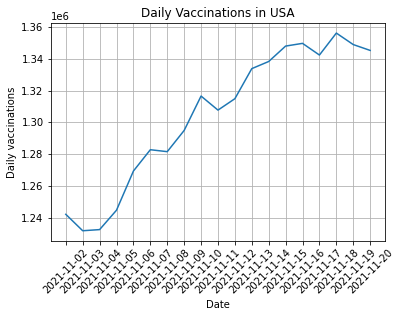

In [114]:
import matplotlib.pyplot as plt
axis_1 = df_vax_weeks_usa['date']
axis_2 = df_vax_weeks_usa['daily_vaccinations']
ano = df_vax_weeks_usa['people_fully_vaccinated']
plt.title("Daily Vaccinations in USA")
plt.ylabel("Daily vaccinations")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.plot(axis_1, axis_2)
plt.grid(True)
plt.show()
# plt.plot(axis_1, ano, '--')

### Daily vaccinations for each brand

In [115]:
# Johnson&Johnson, Moderna, Pfizer/BioNTech
df_brand = pd.read_csv('country_vaccinations_by_manufacturer.csv')

In [116]:
df_brand.head()

,location,date,vaccine,total_vaccinations
0,Austria,2021-01-08,Johnson&Johnson,0
1,Austria,2021-01-08,Moderna,0
2,Austria,2021-01-08,Oxford/AstraZeneca,0
3,Austria,2021-01-08,Pfizer/BioNTech,31315
4,Austria,2021-01-15,Johnson&Johnson,0


In [117]:
df_brand = df_brand.loc[df_brand['location']=='United States']

In [118]:
df_brand_weeks = df_brand.copy()
# df_vax_weeks['date'] = pd.to_datetime(df_vax_weeks['date'], format='%Y%m%d', unit='s')
start_date = '2021-11-01 0:00:00'
end_date = '2021-11-20 23:59:59'
mask = (df_brand_weeks['date'] > start_date) & (df_brand_weeks['date'] <= end_date)

df_brand_weeks = df_brand_weeks.loc[mask]

In [119]:
df_brand_weeks.head()

,location,date,vaccine,total_vaccinations
19226,United States,2021-11-02,Johnson&Johnson,15684476
19227,United States,2021-11-02,Moderna,159747250
19228,United States,2021-11-02,Pfizer/BioNTech,248071961
19229,United States,2021-11-03,Johnson&Johnson,15725873
19230,United States,2021-11-03,Moderna,160450092


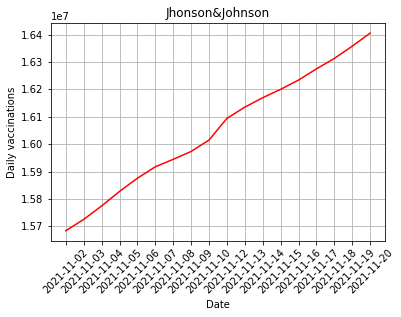

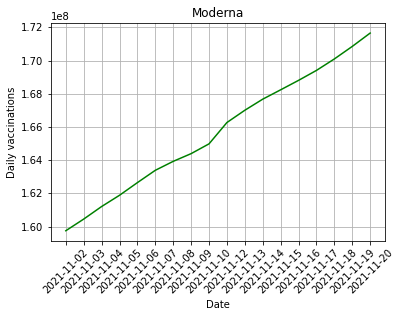

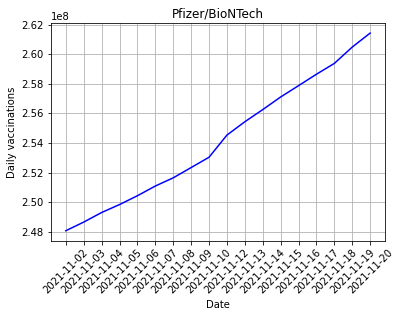

In [124]:
# Johnson&Johnson, Moderna, Pfizer/BioNTech
sel_jj = df_brand_weeks.loc[df_brand_weeks['vaccine']=='Johnson&Johnson']
sel_moderna = df_brand_weeks.loc[df_brand_weeks['vaccine']=='Moderna']
sel_pfizer = df_brand_weeks.loc[df_brand_weeks['vaccine']=='Pfizer/BioNTech']

axis_0 = sel_jj['date']
axis_1 = sel_jj['total_vaccinations']
axis_2 = sel_moderna['total_vaccinations']
axis_3 = sel_pfizer['total_vaccinations']

plt.title("Jhonson&Johnson")
plt.ylabel("Daily vaccinations")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.plot(axis_0, axis_1, 'r', label='Johnson&Johnson')
plt.grid(True)
plt.show()

plt.title("Moderna")
plt.ylabel("Daily vaccinations")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.plot(axis_0, axis_2, 'g', label='Moderna')
plt.grid(True)
plt.show()

plt.title("Pfizer/BioNTech")
plt.ylabel("Daily vaccinations")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.plot(axis_0, axis_3, 'b', label='Pfizer/BioNTech')
plt.grid(True)
plt.show()

# plt.plot(axis_1, ano, '--')